In [224]:
# multivariate multi-step encoder-decoder lstm
import sys
from math import sqrt
from numpy import split
from numpy import array, array_split
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-1701], data[-1701:-7]
	print(train.shape)
	print(test.shape)
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 2, 100, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# checkpoint
	filepath="models/multivariate_multistep_encoderdecoder_lstm_modified.h5"
	checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	model.save('models/multivariate_multistep_encoderdecoder_lstm_modified_.h5')
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [225]:
# load the new file
# file should be household_power_consumption_days.csv
dataset = read_csv('qqq.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
print(len(dataset.values))
dataset.tail()


3081


,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted
datetime,,,,,,
2019-03-25,177.910004,178.839996,176.929993,178.220001,46336500,178.220001
2019-03-26,179.600006,180.690002,178.139999,179.050003,33248100,179.050003
2019-03-27,179.320007,179.720001,176.600006,177.899994,37096700,177.899994
2019-03-28,178.360001,178.979996,177.240005,178.309998,30368200,178.309998
2019-03-29,179.630005,179.830002,178.589996,179.660004,35177400,179.660004


(1379, 6)
(1694, 6)
Epoch 1/100
 - 7s - loss: 8617314801461.4512
Epoch 2/100
 - 2s - loss: 601344914329.2249
Epoch 3/100
 - 2s - loss: 271092732189.0696
Epoch 4/100
 - 2s - loss: 71331433326.4645
Epoch 5/100
 - 2s - loss: 61461948474.5143
Epoch 6/100
 - 2s - loss: 128672501491.8095
Epoch 7/100
 - 2s - loss: 36515311475.7158
Epoch 8/100
 - 2s - loss: 125426664008.8615
Epoch 9/100
 - 2s - loss: 1580750583043.7480
Epoch 10/100
 - 2s - loss: 6279818586.8110
Epoch 11/100
 - 2s - loss: 13270812748.1709
Epoch 12/100
 - 2s - loss: 1157887841.8001
Epoch 13/100
 - 2s - loss: 464443971.1915
Epoch 14/100
 - 2s - loss: 398086272.9253
Epoch 15/100
 - 2s - loss: 1750858160.4954
Epoch 16/100
 - 2s - loss: 1426478829.1615
Epoch 17/100
 - 2s - loss: 596323973.7233
Epoch 18/100
 - 2s - loss: 385230106.8523
Epoch 19/100
 - 2s - loss: 17825659677.3996
Epoch 20/100
 - 2s - loss: 2414159029.8579
Epoch 21/100
 - 2s - loss: 2671784251.8424
Epoch 22/100
 - 2s - loss: 8606956199.7348
Epoch 23/100
 - 2s - loss: 2

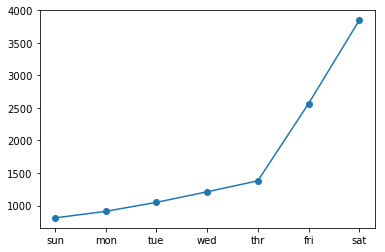

In [226]:
# split into train and test
train, test = split_dataset(dataset.values)
# evaluate model and get scores
n_input = 7
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

In [227]:
import keras
loaded_model = keras.models.load_model('models/multivariate_multistep_encoderdecoder_lstm_modified_.h5')

In [228]:
# loaded_model.predict(split_dataset(dataset.values)[1][-1:])
print((split_dataset(dataset.values)[1][-1:]).shape)
# print((split_dataset(dataset.values)[1][-1:]))
print(dataset.values[-7:])
loaded_model.predict(np.array([dataset.values[-7:]]))

(1379, 6)
(1694, 6)
(1, 7, 6)
[[1.79220001e+02 1.82830002e+02 1.79199997e+02 1.82570007e+02
  4.24285000e+07 1.82570007e+02]
 [1.81779999e+02 1.82270004e+02 1.78369995e+02 1.78559998e+02
  7.07945000e+07 1.78559998e+02]
 [1.77910004e+02 1.78839996e+02 1.76929993e+02 1.78220001e+02
  4.63365000e+07 1.78220001e+02]
 [1.79600006e+02 1.80690002e+02 1.78139999e+02 1.79050003e+02
  3.32481000e+07 1.79050003e+02]
 [1.79320007e+02 1.79720001e+02 1.76600006e+02 1.77899994e+02
  3.70967000e+07 1.77899994e+02]
 [1.78360001e+02 1.78979996e+02 1.77240005e+02 1.78309998e+02
  3.03682000e+07 1.78309998e+02]
 [1.79630005e+02 1.79830002e+02 1.78589996e+02 1.79660004e+02
  3.51774000e+07 1.79660004e+02]]


array([[[0.31144124],
        [0.31144124],
        [0.31144124],
        [0.31144124],
        [0.31144124],
        [0.31144124],
        [0.31144124]]], dtype=float32)